## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

In [2]:
dfs[0].head()

,dd,pop_captured_0,pop_captured_1,pop_captured_2,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,1000,0.01,0,2201


## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [3]:
def compile_diffs(dfs, thresh: int):
    capture_data = []
    for frame in dfs:
        first_capture = frame[frame.pop_captured_0 > thresh].head(1).dd
        first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1).dd
        if not first_capture.empty and not first_emergence.empty:
            diff = first_capture.iloc[0] - first_emergence.iloc[0]
            pop_0 = frame.head(1).pop_0.iloc[0]
            prob_capture = frame.head(1).prob_capture.iloc[0]
            mating_delay = frame.head(1).mating_delay.iloc[0]
            ratio_naive = pop_0 * prob_capture
            ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
            capture_data.append((diff, ratio, ratio_naive, pop_0, prob_capture, mating_delay))
    return capture_data

first_capture_data = compile_diffs(dfs, 1)

Two ratios are generated here for combinations between overwintering pop size and capture probability, a naive ratio just by multiplying them together (yes, I know this technically isn't a ratio since it's not divison, but since one of these values is very big and the other very small, multiplying gives much nicer numbers and is no less valid as a combination of the two than if I chose to multiply), and a better ratio by multiplying the cube root of the population to the cube of the capture probability. This balances out their relative importance in determining the difference much better, as will be demonstrated.

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [4]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

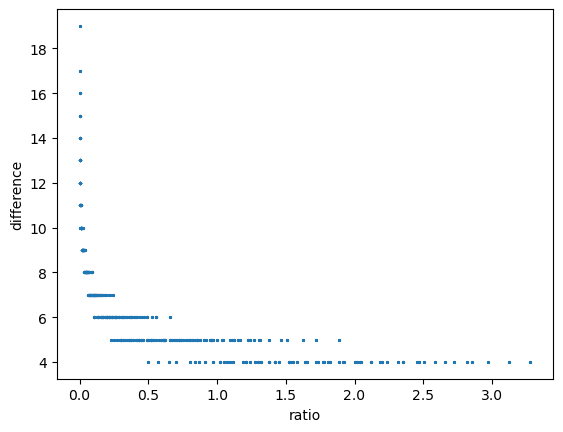

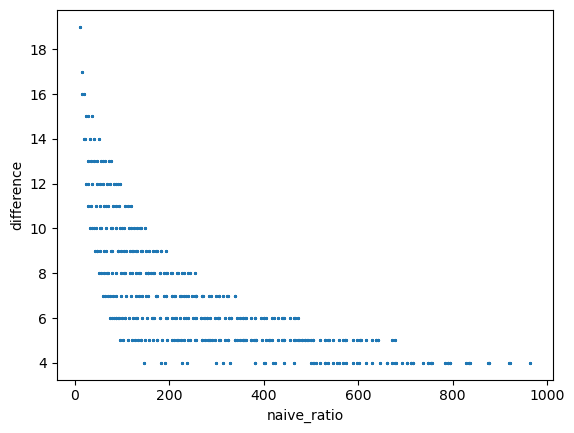

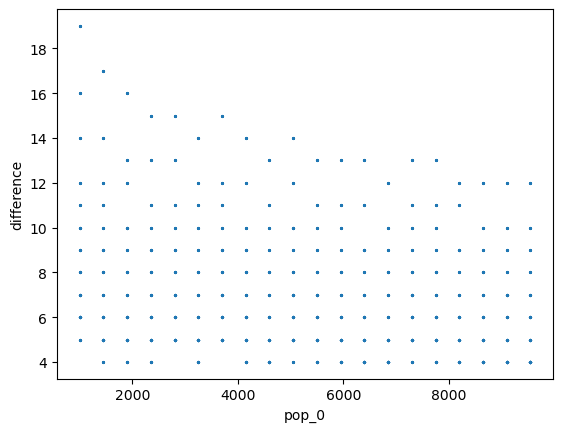

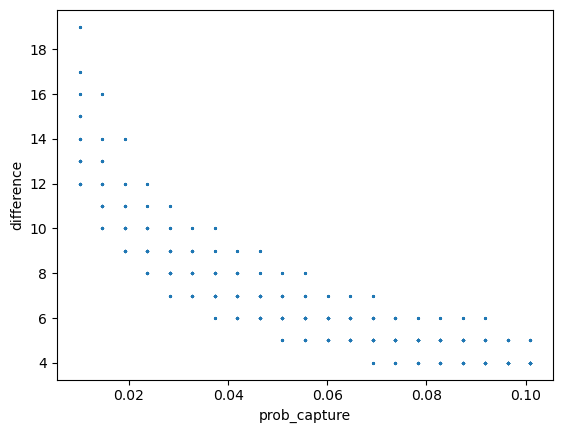

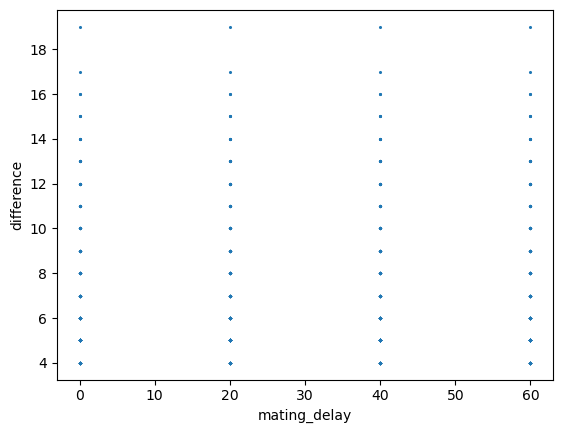

In [5]:
is_log = False
capture_df.plot.scatter(1, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(2, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(3, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(4, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(5, 0, 1.5, loglog=is_log)

## Create function for automatically fitting reciprocal functions using inverse-composition linearization

In [6]:
def autofit_reciprocal(x, y, a_guess, b_guess, c_guess, full_output=False):
    a = a_guess
    b = b_guess
    c = c_guess
    slope = 2
    intercept = 1

    # fit 'b' parameter
    magnitude = 1
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        b_below = b + (0.1 ** magnitude)
        b_above = b - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b_above)), a), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b_below)), a), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        if abs(p[1]) < abs(p_above[1]) and abs(p[1]) < abs(p_below[1]):
            magnitude = magnitude + 1
        elif abs(p_above[1]) < abs(p_below[1]):
            b = b_above
        elif abs(p_below[1]) < abs(p_above[1]):
            b = b_below

    # fit 'a' parameter
    magnitude = 0
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        a_below = a + (0.1 ** magnitude)
        a_above = a - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_above), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_below), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        # print(f'{a}, {p_above[0]}, {p[0]}, {p_below[0]}')
        if abs(p[0] - 1) < abs(p_above[0] - 1) and abs(p[0] - 1) < abs(p_below[0] - 1):
            magnitude = magnitude + 1
        elif abs(p_above[0] - 1) < abs(p_below[0] - 1):
            a = a_above
        elif abs(p_below[0] - 1) < abs(p_above[0] - 1):
            a = a_below
    if full_output:
        return (a, b, p)
    else:
        return (a, b)

## Fit curve to data using naive ratio

0.999996876200253 -3.005990248565872e-13


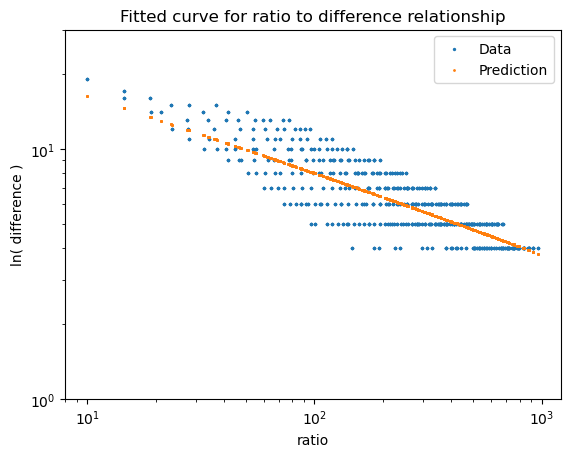

In [7]:
x = capture_df.naive_ratio
y = capture_df.difference

c = 0.29
a, b, p = autofit_reciprocal(x, y, 3, 0.3, c, full_output=True)
print(*p)

y_linear_naive = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y_naive = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y_naive, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()

## Check residuals

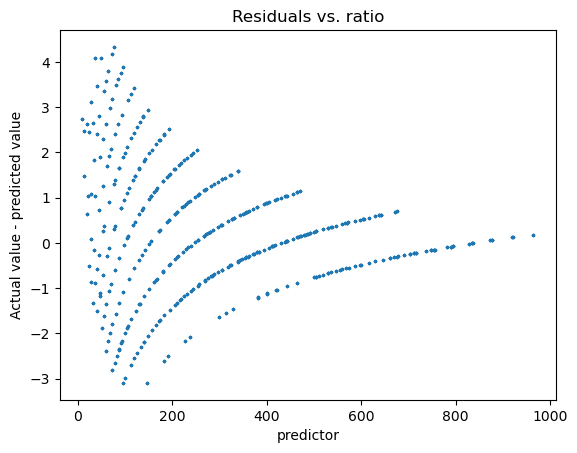

In [8]:
from scipy.stats import zscore

def residual_plot(x, y, fitted_y, log=False):
    data = {'ratio': x, 'residual':np.subtract(y, fitted_y)}
    residuals = pd.DataFrame(data)
    #residuals = residuals[(np.abs(zscore(residuals.residual)) < 4)]
    ax = plt.axes()
    ax.scatter(residuals.ratio, residuals.residual, label='Data', s=2)
    ax.set_title('Residuals vs. ratio')
    ax.set_ylabel('Actual value - predicted value')
    ax.set_xlabel('predictor')
    if log:    
        ax.set_yscale('log')
        ax.set_xscale('log')

residual_plot(x, y, fitted_y_naive)

heteroscedasticity could definitely be improved

## Fit curve to data using smarter ratio

(3.660890776116469, 0.8979282714661776)


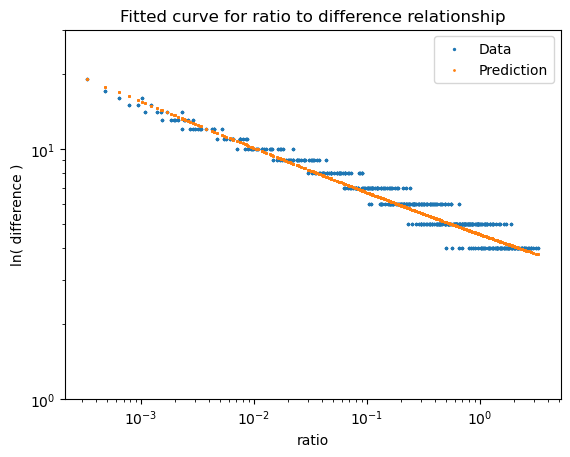

In [9]:
x = capture_df.ratio
y = capture_df.difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

For the ratio function of (pop_0^1/3) * (prob_capture^3), a function of y = (3.024 / x ^ 0.2) + 0.965 predicts the difference in first emergence and first capture.

## Determine goodness of fit by looking at residuals

### Residual Plot

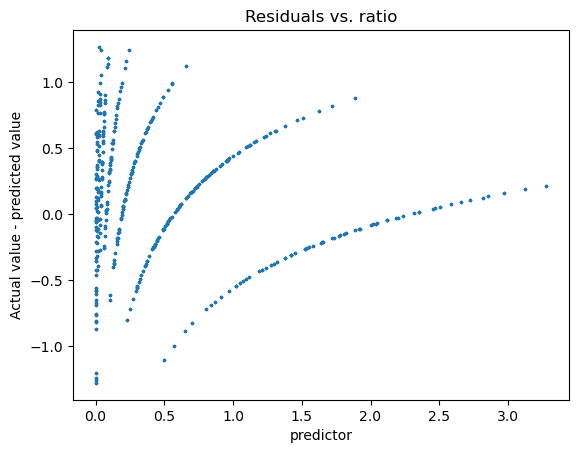

In [10]:
residual_plot(x, y, fitted_y)

Definitely still some heteroscedasticity, but it looks like the worst of it is only +/- 1. Measureable improvement from the naive ratio. Furthermore, from looking at the fitted curve graphs of the two, no value of 'c' was able to match both the extreme and median points to a satisfactory degree with the naive ratio, but a 'c' of 0.2 matches both quite well with the smarter combination

### Average bias per point

In [11]:
np.sum(np.subtract(y, fitted_y)) / len(x)

0.14099709146460362

The fitted curve is a little biased relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.

## At this point I decide to rethink which parameter I want to base the model off of

My rationale is this: One of the biggest issues I'm facing in making this model is the extreme instability around small ratio values, and if you look at the difference vs predictor graphs I have towards the top, you can visually see that it is mostly the fault of the "size of the overwintering population" (pop_0) to blame for this. Furthermore, this parameter would be _very_ difficult to get an actual read on in the field. Furthermore, if I do analysis on the sampling effort with a constant population, then that allows me to trivially apply these differences to the known phenology curves, which are in proportions of total population and not integer moth counts. If the population is kept constant through the first generation, just multiply the phenology curves by that constant number to apply the differences, and then divide again to get back to proportions. The capture probability parameter is both more uniformly stable around small values, and also is actually feasible to estimate in real world situations, so I'm going to generate a new data set, holding both mating delay and pop_0 constant, so as to get a direct look at the effect of the per degree day capture probability with significantly higher resolution. I also had to modify the data output from the simulation to get an integrated energence value, as the current system for using the population active works explicitly only for the first emergence, as any past that are subject to death and capture diminishing the true number of emergences.

## Build DataFrames for the new focused set

In [205]:
df = pd.read_csv('test_2.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

## Investigate also how the difference evolves when looking at second captures, third captures, etc.

### Compile 1st through 300th differences

In [13]:
diffs = []
for i in range(1,150):
    row = compile_diffs(dfs, i)
    row_df = pd.DataFrame(row, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
    diffs.append(row_df)

len(diffs)

149

### Look at the graphs of the first, second, third, fifth, and fiftieth differences against the probability of capture

<Axes: title={'center': 'Fiftieth capture difference'}, xlabel='prob_capture', ylabel='difference'>

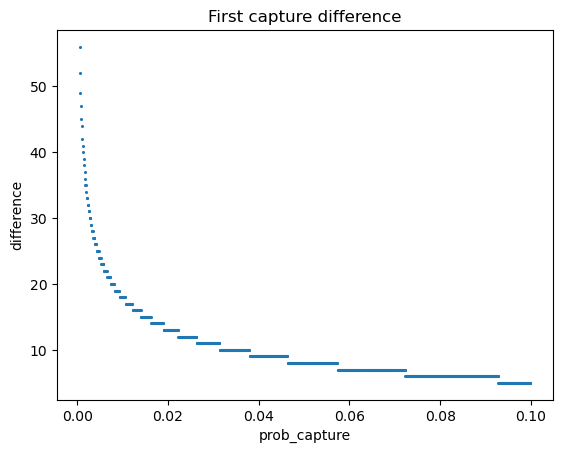

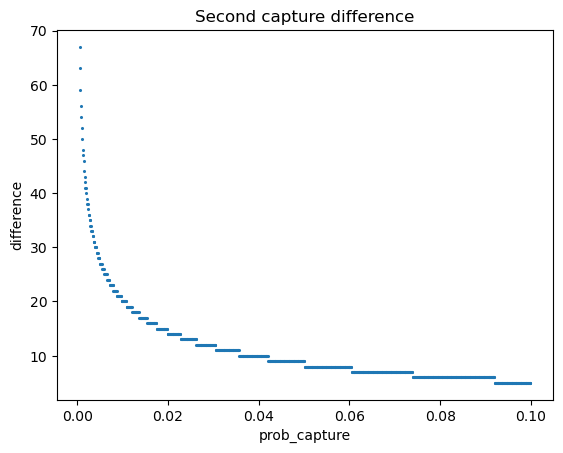

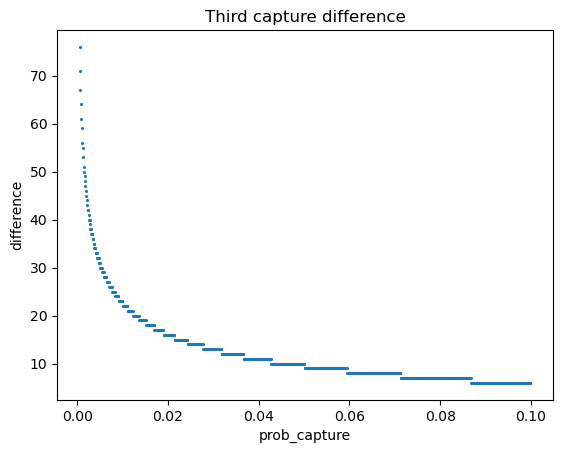

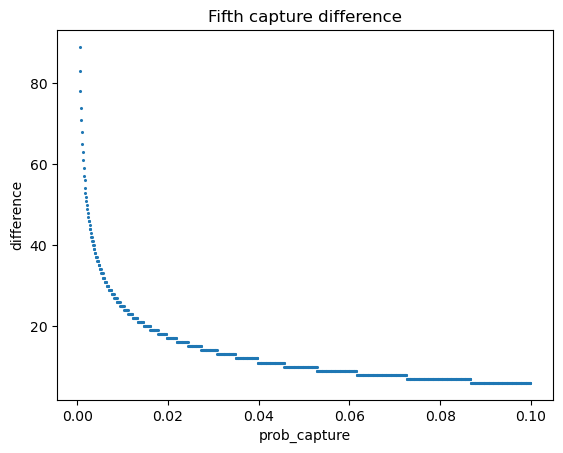

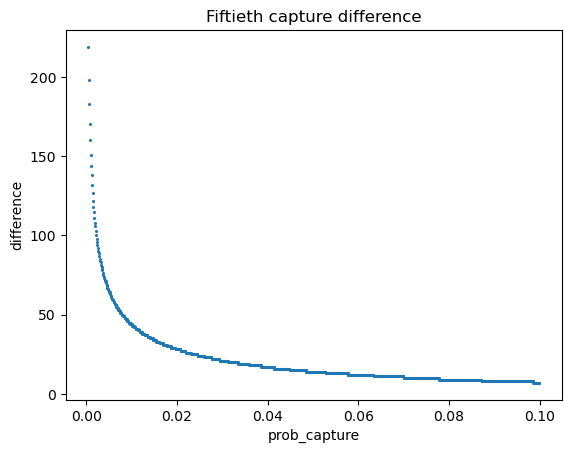

In [14]:
is_log = False
diffs[0].plot.scatter(4, 0, 1.5, title='First capture difference', loglog=is_log)
diffs[1].plot.scatter(4, 0, 1.5, title='Second capture difference', loglog=is_log)
diffs[2].plot.scatter(4, 0, 1.5, title='Third capture difference', loglog=is_log)
diffs[4].plot.scatter(4, 0, 1.5, title='Fifth capture difference', loglog=is_log)
diffs[49].plot.scatter(4, 0, 1.5, title='Fiftieth capture difference', loglog=is_log)

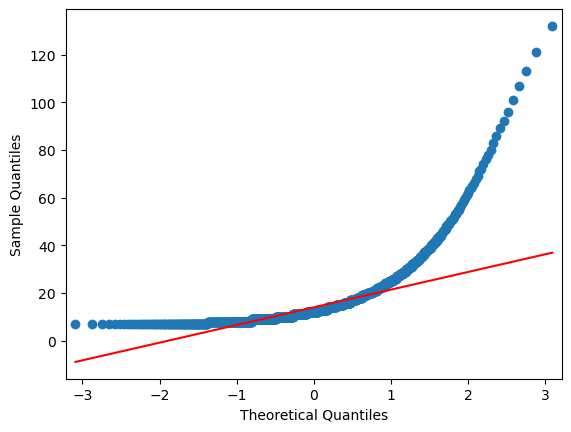

In [15]:
from statsmodels.api import qqplot
_ = qqplot(diffs[14].difference, line='q')

## Make a better fitting function for the more well behaved data

In [16]:
import statsmodels.formula.api as smf

def new_autofit(x, y, residuals=False, full_output=False):
    data = pd.DataFrame({'difference':y, 'prob_capture':x})
    model = smf.ols('np.log(difference) ~ np.log(prob_capture)', data=data).fit()
    if full_output:
        print(model.summary())
    if residuals:
        return (model.params[1], np.exp(model.params[0]), model.resid)
    return (model.params[1], np.exp(model.params[0]))


                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 5.492e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:09:01   Log-Likelihood:                 1148.1
No. Observations:                1000   AIC:                            -2292.
Df Residuals:                     998   BIC:                            -2282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5466 

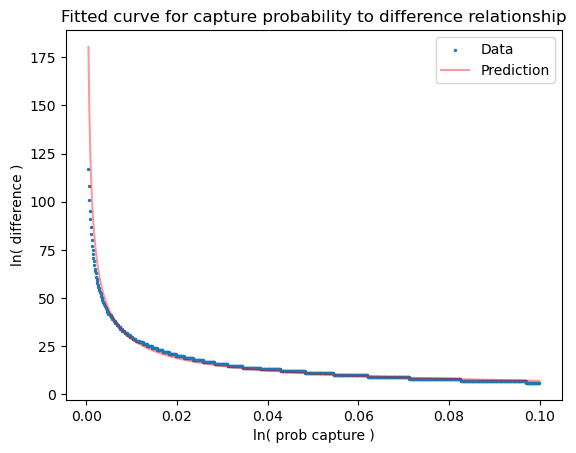

In [17]:
n = 10
x = diffs[n].prob_capture
y = diffs[n].difference

a, b, resid = new_autofit(x, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(x,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for capture probability to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( prob capture )')
ax.legend()

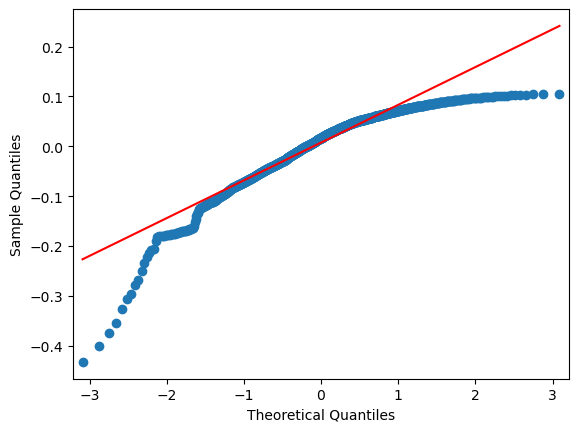

In [18]:
_ = qqplot(resid, line='q')

These residuals aren't perfect but I believe they are well within the realm of acceptability

### Model the change in models!

In [19]:
diffs[1].head()

,difference,ratio,naive_ratio,pop_0,prob_capture,mating_delay
0,67,4.166667e-08,0.5000,1000,0.000500,0
1,63,7.182015e-08,0.5995,1000,0.000599,0
2,59,1.138440e-07,0.6990,1000,0.000699,0
3,56,1.697085e-07,0.7985,1000,0.000798,0
4,54,2.413836e-07,0.8980,1000,0.000898,0


1.7424103608885844


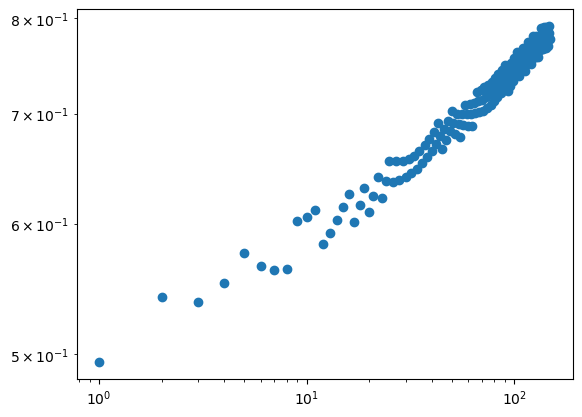

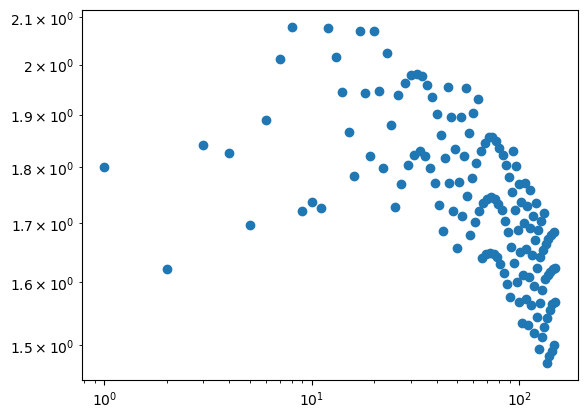

In [20]:
model_mat = []
for diff in diffs:
    a, b = new_autofit(diff.prob_capture, diff.difference)
    model_mat.append((a,b))
    
a = np.array(model_mat).T[0]
a = -a
b = np.array(model_mat).T[1]
x = np.arange(1,len(diffs)+1)

print(np.mean(b))

plt.scatter(x, a)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(x, b)
plt.xscale('log')
plt.yscale('log')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   coef   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     175.0
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           8.32e-27
Time:                        17:09:03   Log-Likelihood:                 139.56
No. Observations:                 149   AIC:                            -275.1
Df Residuals:                     147   BIC:                            -269.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9228      0.016    122.292      0.0

(-0.002405655236677112, 1.9228345036393677, 1.7424103608885844)

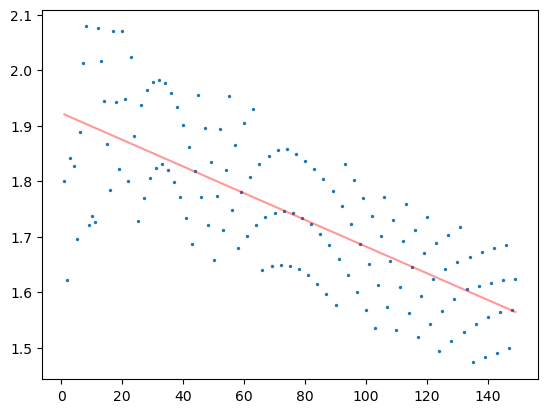

In [21]:
data = pd.DataFrame({'coef':b, 'n_diff':x})
model = smf.ols('coef ~ n_diff', data=data).fit()
b_a = model.params[1]
b_b = model.params[0]
y_fitted = b_b + (b_a*x)
print(model.summary())
ax = plt.axes()
ax.scatter(x, b, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(b_a, b_b, np.mean(b))

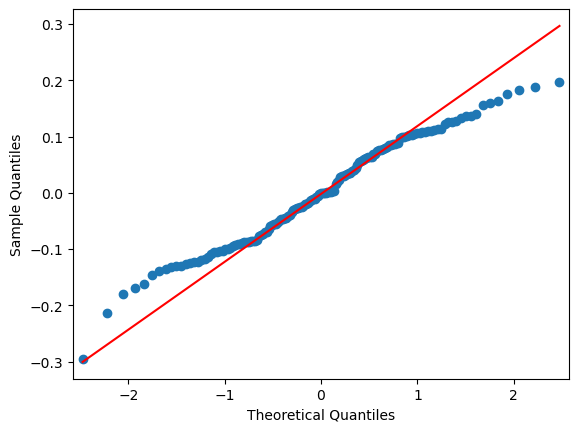

In [22]:
_ = qqplot(model.resid, line='q')

                            OLS Regression Results                            
Dep. Variable:          np.log(power)   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3858.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          2.14e-107
Time:                        17:09:03   Log-Likelihood:                 385.66
No. Observations:                 149   AIC:                            -767.3
Df Residuals:                     147   BIC:                            -761.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7535      0.007   -114.

(0.09895633550553459, 0.47073226934775697)

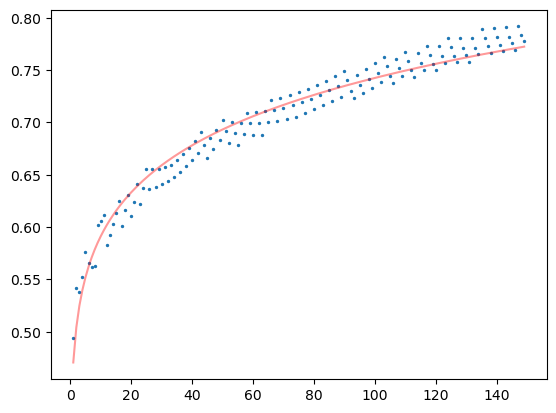

In [23]:
data = pd.DataFrame({'power':a, 'n_diff':x})
model = smf.ols('np.log(power) ~ np.log(n_diff)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
y_fitted = np.multiply(np.power(x,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(x, a, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

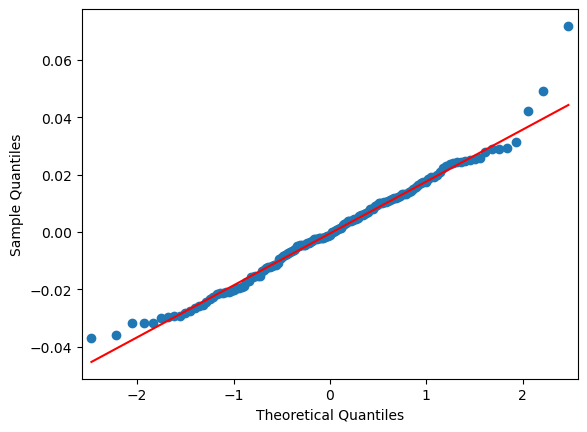

In [24]:
_ = qqplot(model.resid, line='q')

The model for the exponent of the power law is REALLY good, the residuals show that the true distribution may have *ever so slightly* heavier tails than the fitted model, but with such low variance thats something that is totally fine by me.  
The model for the coefficient isn't exactly a perfect fit, but it contributes so little to the overall model that I don't think it's worth the added complexity of making it better. Additionally it would require looking into more data than I already have here, so it's not worth the labor.

### Look at how effort effects the differences

In [206]:
import statsmodels.api as sm
import seaborn as sns
params = []
for m in range(500):
    n = 0
    x = np.arange(1, 80, 1)
    y = [diffs[n].iloc[m].difference for n in x]
    effort = diffs[1].iloc[m].prob_capture
    model = sm.OLS(np.log(y), sm.add_constant(np.log(x))).fit()
    a = model.params[1]
    b = np.exp(model.params[0])
    params.append((effort,a,b))

params = np.array(params)
As = params.T[1]
Bs = params.T[2]0.011
efforts = params.T[0]
plt.figure()
sns.lineplot(x=efforts, y=As)
plt.figure()
sns.lineplot(x=efforts, y=Bs)


SyntaxError: invalid syntax (3595375136.py, line 16)

In [207]:
data = pd.DataFrame({'power':As, 'effort':efforts})
model = smf.ols('np.log(power) ~ np.log(effort)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
a_fitted = np.multiply(np.power(efforts,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(efforts, As, label='Data', s=2)
ax.plot(efforts, a_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

ValueError: All arrays must be of the same length

In [208]:
data = pd.DataFrame({'coef':Bs, 'effort':efforts})
model = smf.ols('np.log(coef) ~ np.log(effort)', data=data).fit()
b_a = model.params[1]
b_b = np.exp(model.params[0])
b_fitted = np.multiply(np.power(efforts,b_a), b_b)
print(model.summary())
ax = plt.axes()
ax.scatter(efforts, Bs, label='Data', s=2)
ax.plot(efforts, b_fitted, label='Prediction', alpha=0.4, color='red')
(b_a, b_b)

ValueError: All arrays must be of the same length

### Fit johnson su distributions for the efforts

0.0999005000000015


(-4.69387644611815, 2.5676166588388796)

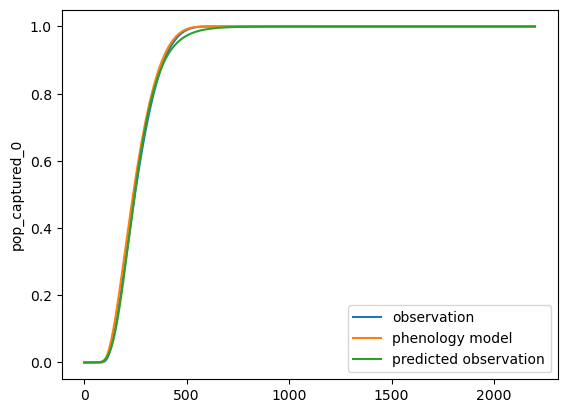

In [209]:
import scipy.stats as sps
import scipy.optimize as spop
from scipy.stats import johnsonsb
from scipy.stats import johnsonsu
import seaborn as sns

n = 999
x_opt = np.arange(0,dfs[n].dd.max()+1,1)
y_opt = dfs[n].pop_captured_0 / 1000
f = lambda dd, gamma, delta: johnsonsu.cdf(dd, gamma, delta, loc=27.5, scale=72.31)
#[-4.8689+(0.3*n),2.0689+(0.06*n),27.503-(7*n),72.3-(3.75*n)]
gamma, delta = spop.curve_fit(f,x_opt,y_opt,p0=[-7.08,  2.29])[0]
y_pred = johnsonsu.cdf(x_opt,gamma, delta, loc=27.5, scale=72.31)
sns.lineplot(x=x_opt, y=y_opt, label='observation')
sns.lineplot(x=x_opt, y=dfs[n].pop_emerged_0/1000, label='phenology model')
sns.lineplot(x=x_opt, y=y_pred, label='predicted observation')
print(dfs[n].head(1).prob_capture.item())
gamma, delta

In [29]:
f = lambda dd, gamma, delta: johnsonsu.cdf(dd, gamma, delta, loc=27.5, scale=72.31)

params = []
for n in range(1000):
    x_opt = np.arange(0,dfs[n].dd.max()+1,1)
    y_opt = dfs[n].pop_captured_0 / 1000
    effort = dfs[n].head(1).prob_capture.item()
    gamma, delta = spop.curve_fit(f,x_opt,y_opt,p0=[-7.08,  2.29])[0]
    params.append((gamma, delta, effort))
    

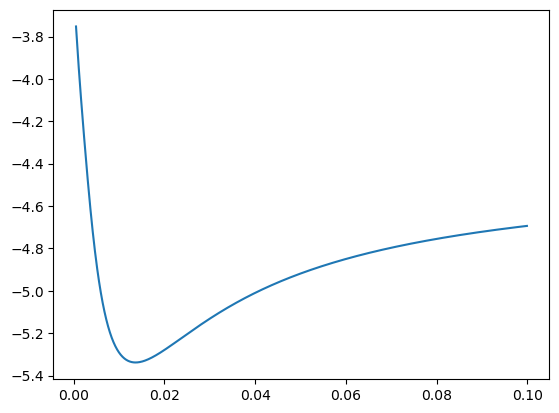

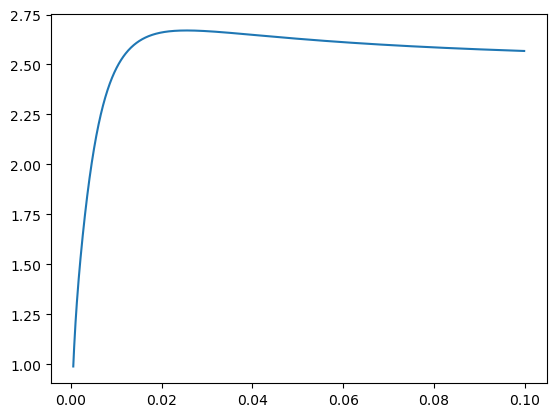

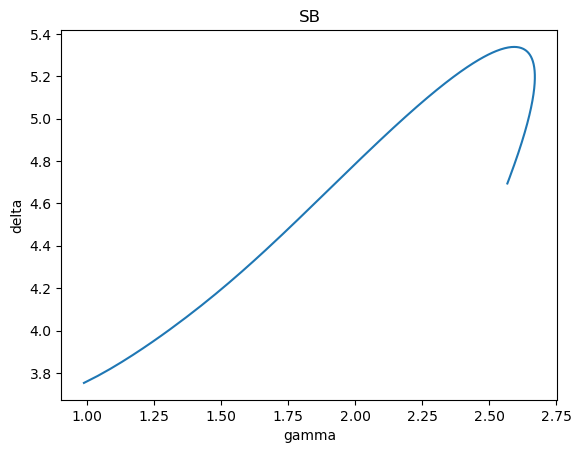

In [30]:
params = np.array(params).T
gammas = params[0]
deltas = params[1]
efforts = params[2]

plt.plot(efforts,gammas)
plt.figure()
plt.plot(efforts,deltas)
plt.figure()
plt.title('SB')
plt.xlabel('gamma')
plt.ylabel('delta')
plt.plot(deltas,-gammas)

#### fit functions for these relationships

-3251828915.427764 -29494386.634669527 -72669.5073246605 740.4344563059263 -3.581945353194297 738165660.7315745 1360371.4216180712 56907.26626775667 -306.2510492876186
-4.436820286359018


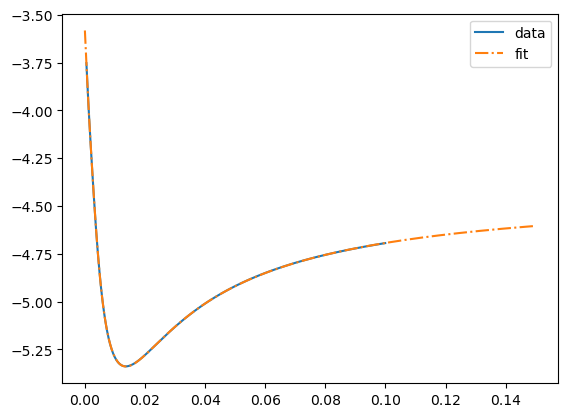

In [31]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rationaln_n(x, p0, p1, p2, p3, p4, q1, q2, q3, q4):
    return rational(x, [p0, p1, p2, p3, p4], [q1, q2, q3, q4])
popt_gammas_su, pcov_gammas_su = spop.curve_fit(rationaln_n, efforts, gammas)

effortspaced = np.linspace(0,0.15,10000)

plt.plot(efforts, gammas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_gammas_su), label='fit', linestyle='-.')
plt.legend()
print(*popt_gammas_su)
print(rationaln_n(1, *popt_gammas_su))

1547130778.812226 -11245546.619027564 -466614.6942582969 -442.5232425234668 0.8521002984014721 628826757.7638363 -7875051.791039231 -83165.24056761258 -964.3410129443149
2.4730203858919046


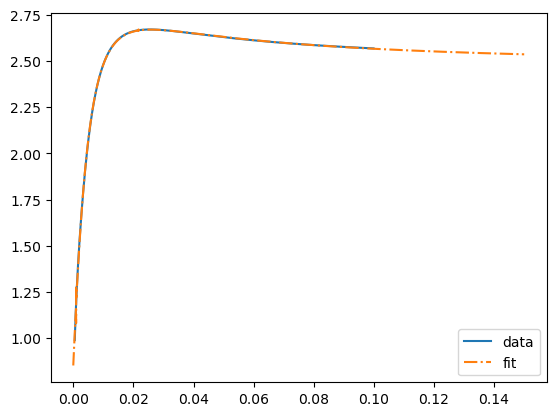

In [32]:
popt_deltas_su, pcov_deltas_su = spop.curve_fit(rationaln_n, efforts, deltas,p0=[1,1,1,1,1000,-1,1,1,-1000])

plt.plot(efforts, deltas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_deltas_su), label='fit', linestyle='-.')
plt.legend()
print(*popt_deltas_su)
print(rationaln_n(1, *popt_deltas_su))

### fit johnson sb distributions for the efforts

0.0014949999999999


(3.3406016425918543, 1.1890185573424294, 11541.547672743964)

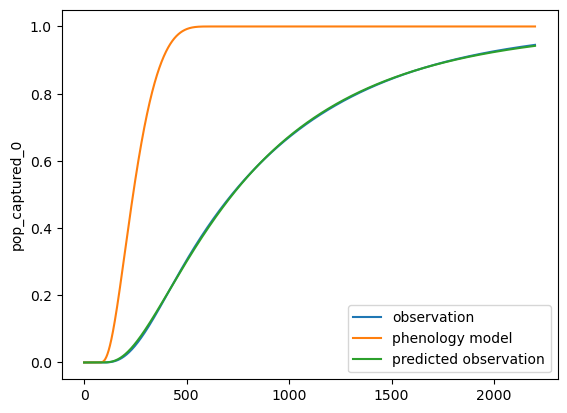

In [216]:
import scipy.stats as sps
import scipy.optimize as spop
from scipy.stats import johnsonsb
from scipy.stats import johnsonsu

n = 10
x_opt = np.arange(0,dfs[n].dd.max()+1,1)
y_opt = dfs[n].pop_captured_0 / 1000
loc = 69
f = lambda dd, gamma, delta, xi: johnsonsb.cdf(dd, gamma, delta, loc=loc, scale=xi)
#[-4.8689+(0.3*n),2.0689+(0.06*n),27.503-(7*n),72.3-(3.75*n)]
gamma, delta, xi = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
#gamma = 1.0737
#delta = 1.2349
y_pred = johnsonsb.cdf(x_opt,gamma, delta, loc=loc, scale=xi)
sns.lineplot(x=x_opt, y=y_opt, label='observation')
sns.lineplot(x=x_opt, y=dfs[n].pop_emerged_0/1000, label='phenology model')
sns.lineplot(x=x_opt, y=y_pred, label='predicted observation')
print(dfs[n].head(1).prob_capture.item())
gamma, delta, xi

#### model the way the the capture diverges from the phenology model

In [34]:
f = lambda dd, gamma, delta, llambda: johnsonsb.cdf(dd, gamma, delta, loc=69, scale=llambda)
params = []
for n in range(1000):
    x_opt = np.arange(0,dfs[n].dd.max()+1,1)
    y_opt = dfs[n].pop_captured_0 / 1000
    effort = dfs[n].head(1).prob_capture.item()
    gamma, delta, llambda = spop.curve_fit(f,x_opt,y_opt,p0=[1.07,1.2349,  577])[0]
    params.append((gamma, delta, llambda, effort))

params = np.array(params).T
gammas = params[0]
deltas = params[1]
lambdas = params[2]
efforts = params[3]

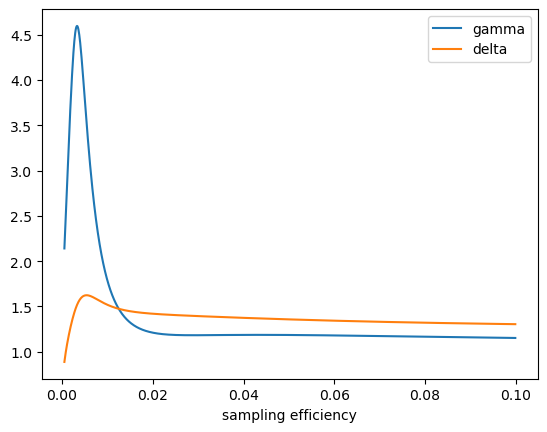

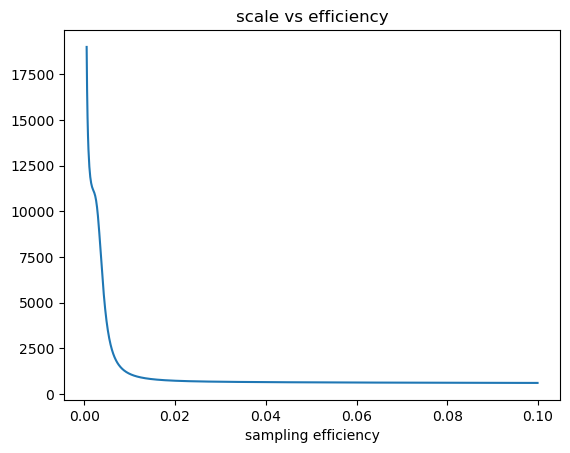

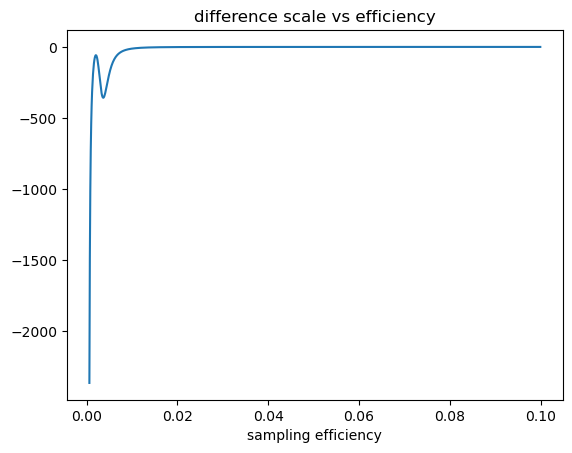

In [35]:
plt.xlabel('sampling efficiency')
sns.lineplot(x=efforts,y=gammas, label='gamma')
sns.lineplot(x=efforts,y=deltas, label='delta')
plt.figure()
plt.title('scale vs efficiency')
plt.xlabel('sampling efficiency')
plt.plot(efforts,lambdas)
plt.figure()
plt.title('difference scale vs efficiency')
plt.xlabel('sampling efficiency')
plt.plot(efforts[1:],np.diff(lambdas))

126265465.59684286 736221.8959032695 13332.256952405249 334.65989977530245 1.6984372693520218 120413098.30657667 -924004.5893391584 65919.69529005302 -317.1106469632625
1.0624037279548832


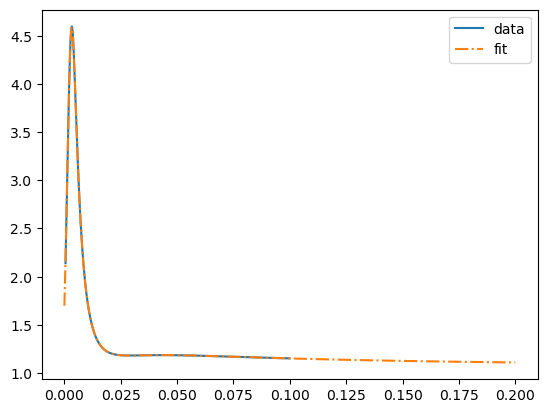

In [36]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rationaln_n(x, p0, p1, p2, p3, p4, q1, q2, q3, q4):
    return rational(x, [p0, p1, p2, p3, p4], [q1, q2, q3, q4])
popt_gammas, pcov_gammas = spop.curve_fit(rationaln_n, efforts, gammas)

effortspaced = np.linspace(0,0.2,5000)

plt.plot(efforts, gammas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_gammas), label='fit', linestyle='-.')
plt.legend()
print(*popt_gammas)
print(rationaln_n(1, *popt_gammas))

202079171.49474132 7736313.043943313 -34506.41893521196 437.6382625137539 0.7130542737774402 168914955.90812212 4317538.170333093 -1401.9548045371614 64.43123694540152
1.2109912525672397


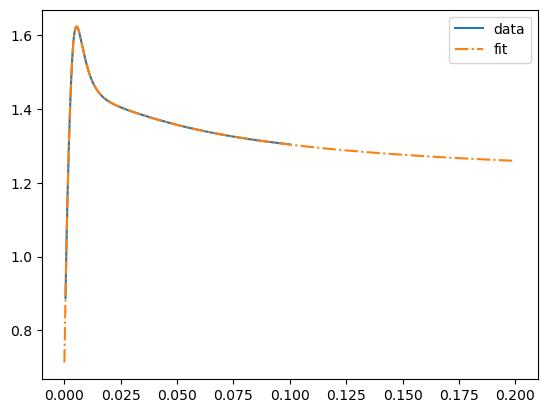

In [37]:
popt_deltas, pcov_deltas = spop.curve_fit(rationaln_n, efforts, deltas)

plt.plot(efforts, deltas, label='data')
plt.plot(effortspaced, rationaln_n(effortspaced, *popt_deltas), label='fit', linestyle='-.')
plt.legend()
print(*popt_deltas)
print(rationaln_n(1, *popt_deltas))

0.44119796355389007
1.1493792602851443
35.110340180075916
0.0022809509065793983
0.0011045156276954628


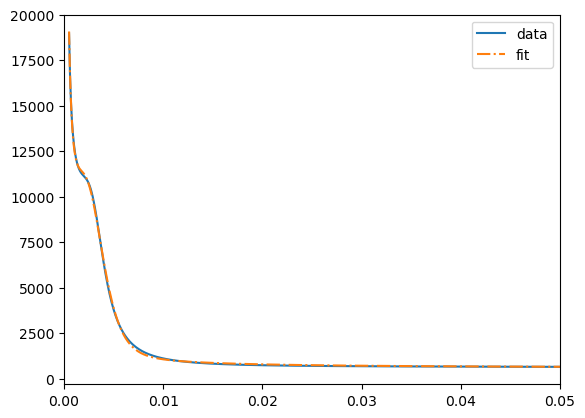

In [41]:
from scipy.stats import logistic

f_lambda = lambda x, b_0, b_1, b_2, b_3, b_4: np.reciprocal(b_0 * (x ** b_1)) + 577 + (b_2 * logistic.pdf(x, loc=b_3, scale=b_4)) 
effortspaced_lambda = np.linspace(0.0005,0.1,5000)
popt_lambdas, pcov_lambdas = spop.curve_fit(f_lambda, efforts, lambdas, p0=[2.5, 1.5, 40, 0.00225, 0.0013])
#popt_lambdas = [2.5, 1.5, 5000, 0.0025, 0.0013]
plt.plot(efforts, lambdas, label='data')
plt.plot(effortspaced_lambda, f_lambda(effortspaced_lambda, *popt_lambdas), label='fit', linestyle='-.')
plt.legend()
plt.xlim(0,0.05)
for coef in popt_lambdas:
    print(coef)

### Shifting emergence data to meet capture data

In [217]:
def capture_prediction_su(dd, effort, max):
    gamma = rationaln_n(effort, *popt_gammas_su)
    delta = rationaln_n(effort, *popt_deltas_su)
    xi = 27.5
    llambda = 72.31
    return max * johnsonsu.cdf(dd, gamma, delta, loc=xi, scale=llambda)

def capture_prediction_sb(dd, effort, max, print_coef=False):
    gamma = rationaln_n(effort, *popt_gammas)
    delta = rationaln_n(effort, *popt_deltas)
    llambda = f_lambda(effort, *popt_lambdas)
    xi = 69
    if print_coef:
        print(f'{gamma}, {delta}, {llambda}')
    return max * johnsonsb.cdf(dd, gamma, delta, loc=xi, scale=llambda)

def jw_emergence(dd, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return max * johnsonsb.cdf(dd, gamma, delta, loc=zeta, scale=llambda)
def inv_jw_emergence(moths, max):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return johnsonsb.ppf((moths/max), gamma, delta, loc=zeta, scale=llambda)

0.00249

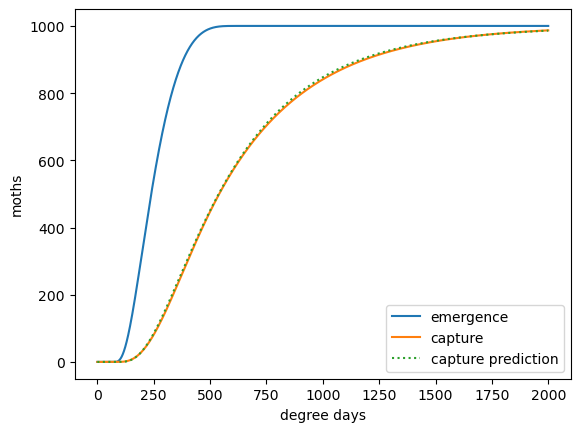

In [218]:
shift_data = dfs[20]
x = shift_data.dd
y_emerge = shift_data.pop_emerged_0
y_capture = shift_data.pop_captured_0
effort = shift_data.head(1).prob_capture.item()
max_time = 2000

y_max = y_capture.max()
func_adj_y = capture_prediction_sb(x, effort, 1000)
ax = sns.lineplot(x=x[0:max_time], y=y_emerge[0:max_time], label='emergence')
ax = sns.lineplot(x=x[0:max_time], y=y_capture[0:max_time], label='capture')
ax = sns.lineplot(x=x[0:max_time], y=func_adj_y[0:max_time], label='capture prediction', linestyle=':')
ax.set(xlabel='degree days', ylabel='moths')
effort

## Analysis of Field Data

### Data prep and looks at dd~diff slices

In [66]:
oksir = pd.read_csv('region_A1a.csv')
oksir.head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [67]:
years = oksir.Year.unique()
oksir_year = {}
for year in years:
    oksir_year[year] = oksir[oksir['Year'] == year]
oksir_year[2015].head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [68]:
def num_traps(data):
    return len(data.X.unique())

At this point I realize that I need to combine this very granular dataset with an integrated one I also have. Only issue is that it doesn't have year information. I need to use the first date and the first capture date to match them together.

In [69]:
years

array([2015, 2014, 2004, 1998, 2009, 2001, 2007, 2013, 2000, 2002, 1995,
       1996, 1999, 2006, 2008, 2010, 2005, 1997, 2012, 2011])

In [70]:
year_jul = []
for year in years:
    year_jul.append((year, \
                     oksir_year[year].head(1).julian.item(), \
                     oksir_year[year][oksir_year[year]['Wild'] > 0.9].head(1).julian.item()))
year_jul
years_table = pd.DataFrame(columns=['year','first_julian','first_capture_julian'], data=year_jul)
years_table

,year,first_julian,first_capture_julian
0,2015,103,119
1,2014,105,126
2,2004,109,116
3,1998,110,117
4,2009,110,132
5,2001,112,133
6,2007,114,120
7,2013,114,133
8,2000,115,115
9,2002,119,133


In [71]:
data_agg = pd.read_csv('region_A1a_aggregated.csv')
data_agg.head()

,Unnamed: 0,julian,moths,var,traps,pr0,DDs,trap_group
0,1,121,1.784615,11.178056,130,0.000000,198.993791,1
1,2,128,7.198473,90.452613,131,0.000000,253.448087,1
2,3,135,9.598485,122.211601,132,0.051529,328.473335,1
3,4,142,8.946970,106.020067,132,0.000000,413.464368,1
4,5,149,4.098485,32.394807,132,0.000000,527.562890,1


In [72]:
data_agg['moths_whole'] = data_agg['moths'] * data_agg['traps']
data_agg = data_agg.drop(columns=['Unnamed: 0'])

In [73]:
data_agg.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole
0,121,1.784615,11.178056,130,0.000000,198.993791,1,232.0
1,128,7.198473,90.452613,131,0.000000,253.448087,1,943.0
2,135,9.598485,122.211601,132,0.051529,328.473335,1,1267.0
3,142,8.946970,106.020067,132,0.000000,413.464368,1,1181.0
4,149,4.098485,32.394807,132,0.000000,527.562890,1,541.0


In [74]:
years_table_unique = years_table.drop_duplicates(subset=['first_julian', 'first_capture_julian'], keep=False) 
group_year_lut = np.zeros(20)
for group in range(len(group_year_lut)):
    first = years_table_unique['first_julian']
    capture = years_table_unique['first_capture_julian']
    agg_grouped = data_agg[data_agg['trap_group'] == group + 1]
    agg_first = agg_grouped.head(1).julian.item()
    agg_capture = agg_grouped[agg_grouped['moths'] > 0].head(1).julian.item()
    year_table_row = years_table_unique[(first == agg_first) & (capture == agg_capture)]
    if len(year_table_row) == 0:
        group_year_lut[group] = None
    else:
        group_year_lut[group] = year_table_row.year.item()

print(group_year_lut)

[  nan   nan 1997. 1998.   nan 2000. 2001. 2002. 2004. 2005.   nan 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]


In [75]:
data_agg['year'] = data_agg.trap_group.apply(lambda x: group_year_lut[x-1])
data_agg_clean = data_agg.dropna()

In [76]:
data_agg_clean.head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year
38,126,0.145078,0.176759,193,0.636875,185.932829,3,28.0,1997.0
39,133,0.589474,2.814703,190,0.000000,278.701708,3,112.0,1997.0
40,140,1.520408,13.409838,196,0.000000,378.042837,3,298.0,1997.0
41,147,0.807107,8.564643,197,0.000000,449.430991,3,159.0,1997.0
42,154,1.137056,7.098467,197,0.000000,545.636534,3,224.0,1997.0


In [81]:
# Split frame into array of frames by year
aggs = [y for x, y in data_agg_clean.groupby('year')]
aggs[0].head()

,julian,moths,var,traps,pr0,DDs,trap_group,moths_whole,year
38,126,0.145078,0.176759,193,0.636875,185.932829,3,28.0,1997.0
39,133,0.589474,2.814703,190,0.000000,278.701708,3,112.0,1997.0
40,140,1.520408,13.409838,196,0.000000,378.042837,3,298.0,1997.0
41,147,0.807107,8.564643,197,0.000000,449.430991,3,159.0,1997.0
42,154,1.137056,7.098467,197,0.000000,545.636534,3,224.0,1997.0


In [82]:
for frame in aggs:
    frame['moth_sum'] = frame['moths_whole'].cumsum()

aggs[4].head()
aggs = aggs[2:] # Inspection showed that 1997 and 1998 had consistently VERY delayed captured across the board, even compared to other years with low trap counts.
                # From this I concluded that those years had drastically low population sizes, so I've decided to get rid of them as outliers.

In [83]:
print(num_traps(oksir_year[2002]))
del aggs[2] # I don't even know what was going on with 2002. It was bouncing around like crazy, being stuck at a really low number for a long time before jumping up to being rediculously
            # larger than the others. Decided to exclude it as an outlier as well due to it's unreasonable erraticism when compared to the other points in the cohort.

123


#### Extract first differences from data

In [84]:
diffs_field = []
for i in range(25):
    acc = []
    for frame in aggs:
        first_capture_row = frame[(frame['moth_sum'] > 5*i)].head(1)
        first_emergence = inv_jw_emergence(5*i, frame.moth_sum.max())
        if len(first_capture_row) == 0:
            continue
        first_capture = first_capture_row.DDs.item()
        traps = num_traps(oksir_year[int(first_capture_row.year.item())])
        acc.append((traps, first_capture - first_emergence))
    diffs_field.append(np.array(acc).T)
diffs_field[0]

array([[396.        , 390.        , 370.        , 365.        ,
        320.        , 298.        , 271.        , 265.        ,
        262.        , 254.        , 253.        , 250.        ,
        249.        ],
       [123.47041156, 212.662073  , 176.30079665, 216.57554165,
        154.10404756,  55.48364563, 145.62099489, 141.82771364,
         76.22034197, 199.82825051, 300.88024319, 157.95241801,
        195.39448517]])

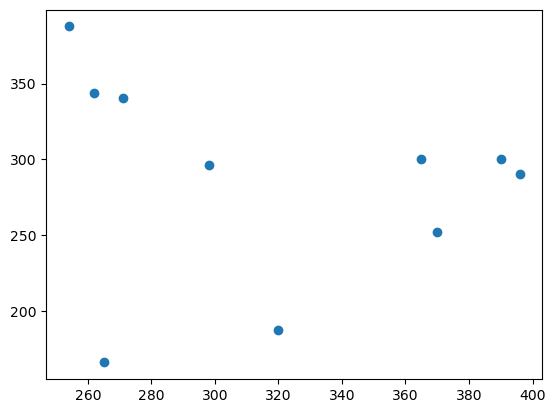

In [85]:
plt.scatter(diffs_field[20][0], diffs_field[20][1])

                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.3681
Date:                Mon, 04 Dec 2023   Prob (F-statistic):              0.561
Time:                        17:48:01   Log-Likelihood:                -7.1384
No. Observations:                  10   AIC:                             18.28
Df Residuals:                       8   BIC:                             18.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.1495 

/usr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


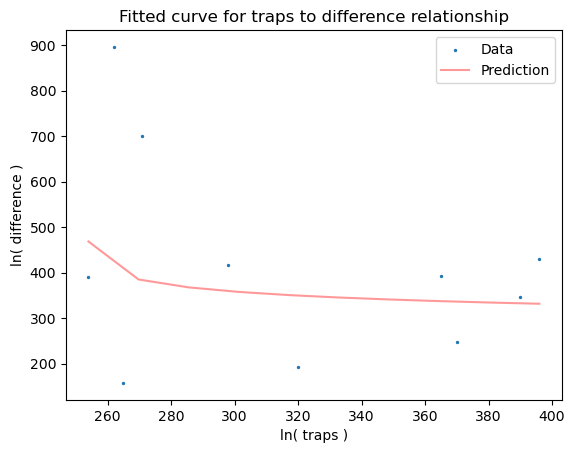

In [86]:
n = 24
x = diffs_field[n][0]
y = diffs_field[n][1]
a, b, resid = new_autofit(x-x.min()+1, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(fitted_x-x.min()+1,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(fitted_x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for traps to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( traps )')
ax.legend()

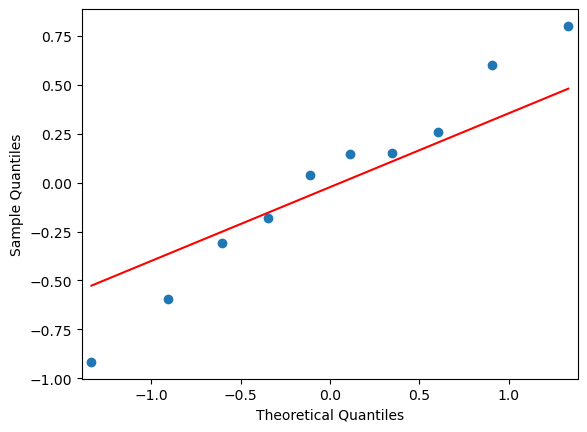

In [87]:
_ = qqplot(resid, line='q')

### Capture curve predictions on field data

<Axes: title={'center': 'OKSIR 2001 data'}, xlabel='Degree days', ylabel='Moths'>

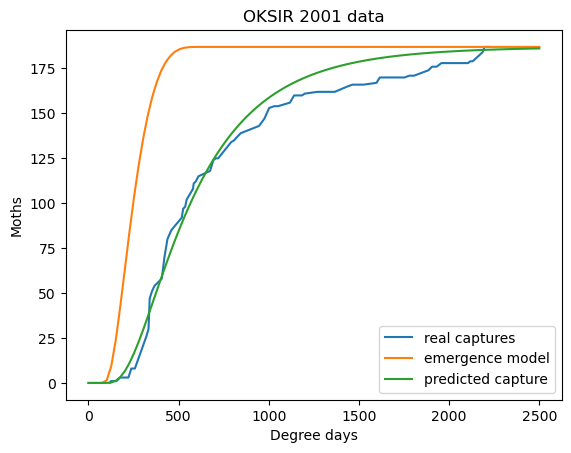

In [93]:
n = 5
phenology_x = np.linspace(0,2500, 100)
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
y_max = aggs[n][aggs[n].DDs < 2500].moth_sum.max()
phenology_y = [jw_emergence(x, y_max) for x in phenology_x]
adj_y = capture_prediction_sb(phenology_x, 0.0025, y_max)
ax = plt.title(f'OKSIR {years[n]} data')
ax = plt.xlabel('Degree days')
ax = plt.ylabel('Moths')
ax = sns.lineplot(x=capture_x, y=capture_y, label='real captures')
ax = sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
sns.lineplot(x=phenology_x, y=adj_y, label='predicted capture')
#sns.lineplot(x=capture_x, y=adj_y, label='predicted capture')

### Prediction training for real-world use

0.004367592509346676
(0.005239988154468775, 116.39802660102615)


<Axes: title={'center': 'OKSIR 2000 data'}, xlabel='Degree days', ylabel='Moths'>

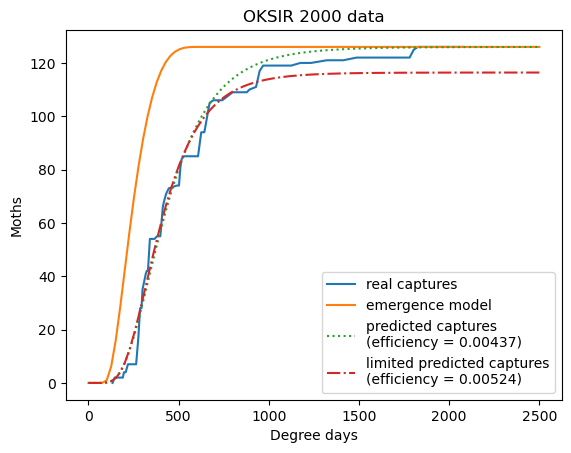

In [94]:
def predict_from_subset(dds, captures):
    f = lambda dd, effort, max: capture_prediction_sb(dd, effort, max)
    effort, max = spop.curve_fit(f,dds,captures,p0=[0.005,  500])[0]
    return (effort, max)
def predict_from_full(dds, captures):
    f = lambda dd, effort: capture_prediction_sb(dd, effort, np.max(captures))
    effort = spop.curve_fit(f,dds,captures,p0=[0.005])[0][0]
    return effort

n = 8
capture_x = aggs[n].DDs
capture_y = aggs[n].moth_sum
limit = capture_x.tail(1).item()*0.5
obs_x = capture_x[capture_x < limit]
obs_y = capture_y[:len(obs_x)]
effort_pred = predict_from_full(capture_x, capture_y)
effort_pred_lim, max_pred_lim = predict_from_subset(obs_x, obs_y)
print(effort_pred)
print((effort_pred_lim, max_pred_lim))
phenology_x = np.linspace(0,2500, 100)
true_max = aggs[n][aggs[n].DDs < 2500].moth_sum.max()
phenology_y = [jw_emergence(x, true_max) for x in phenology_x]
adj_y = capture_prediction_su(phenology_x, effort_pred, true_max)
adj_y_lim = capture_prediction_su(phenology_x, effort_pred_lim, max_pred_lim)
ax = plt.title(f'OKSIR {years[n]} data')
plt.xlabel('Degree days')
plt.ylabel('Moths')
sns.lineplot(x=capture_x, y=capture_y, label='real captures')
sns.lineplot(x=phenology_x, y=phenology_y, label='emergence model')
sns.lineplot(x=phenology_x, y=adj_y, label=f'predicted captures\n(efficiency = {effort_pred.round(5)})', linestyle=':')
sns.lineplot(x=phenology_x, y=adj_y_lim, label=f'limited predicted captures\n(efficiency = {effort_pred_lim.round(5)})', linestyle='-.') 

/usr/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     5.036
Date:                Mon, 04 Dec 2023   Prob (F-statistic):             0.0464
Time:                        17:48:04   Log-Likelihood:                 74.929
No. Observations:                  13   AIC:                            -145.9
Df Residuals:                      11   BIC:                            -144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.032      0.067      -0.000       0.003
x1          5.493e-06   2.45e-06      2.244      0.046    1.06e-07    1.09e-05
==============================================================================
Omnibus:                        0.665   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.598
Skew:                          -0.131   Prob(JB):                        0.742
Kurtosis:                       1.982   Cond. No.                         894.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

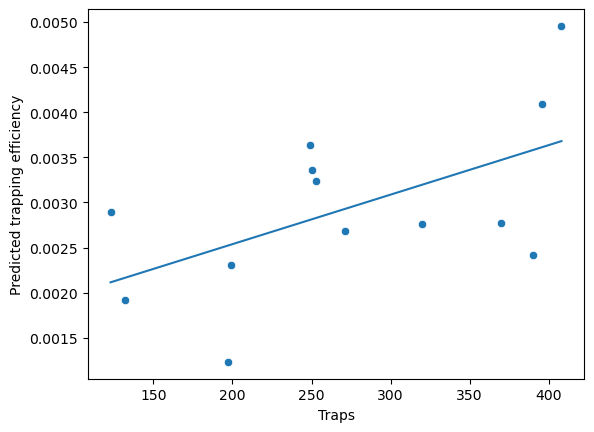

In [90]:
import statsmodels.api as sm

effort_traps = []
for n, agg in enumerate(aggs):
    capture_x = aggs[n].DDs
    capture_y = aggs[n].moth_sum
    limit = capture_x.tail(1).item()*0.5
    obs_x = capture_x[capture_x < limit]
    obs_y = capture_y[:len(obs_x)]
    effort_pred_loop = predict_from_full(capture_x, capture_y)
    effort_pred_loop_lim, _ = predict_from_subset(obs_x, obs_y)
    traps_loop = num_traps(oksir_year[years[n]])
    if np.abs(1 - (effort_pred_loop_lim/effort_pred_loop)) >= 1:
        effort_traps.append((effort_pred_loop_lim, traps_loop))
    else:
        effort_traps.append((effort_pred_loop, traps_loop))

effort_traps = np.array(effort_traps).T

model_effort_traps = sm.OLS(effort_traps[0], sm.add_constant(effort_traps[1])).fit()
y_pred_effort_traps = model_effort_traps.predict(sm.add_constant(effort_traps[1]))
sns.scatterplot(x=effort_traps[1], y=effort_traps[0])
sns.lineplot(x=effort_traps[1], y=y_pred_effort_traps)
plt.xlabel('Traps')
plt.ylabel('Predicted trapping efficiency')
model_effort_traps.summary()

### verification through mass-trap data

### max trap capture to total pop size

In [103]:
df = pd.read_csv('test_3.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

In [111]:
max_captures = [(frame.tail(1).pop_captured_0.item()/1000, frame.tail(1).prob_capture.item()) for frame in dfs]
max_captures = np.array(max_captures).T

array([-8.08978083])

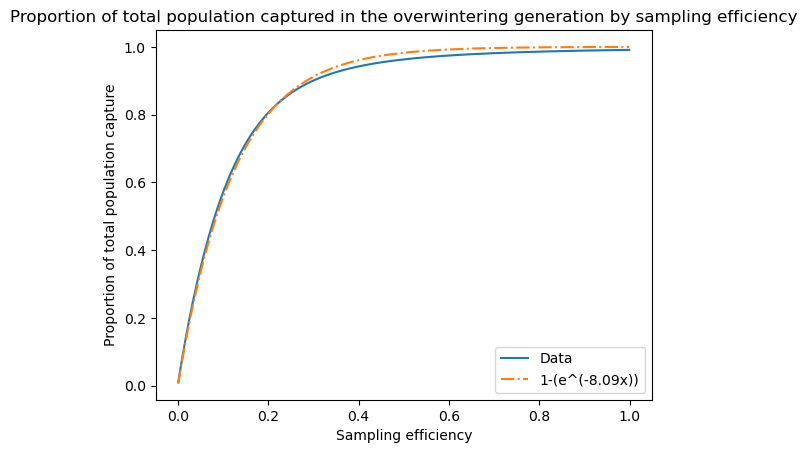

In [225]:
f_f = lambda x, a: (1 - np.exp(a*x))

sns.lineplot(x=max_captures[1], y=max_captures[0], label='Data')

a, b = spop.curve_fit(f_f, max_captures[1], max_captures[0])

sns.lineplot(x=max_captures[1], y=f_f(max_captures[1], a), label='1-(e^(-8.09x))', linestyle='-.')
plt.title('Proportion of total population captured in the overwintering generation by sampling efficiency')
plt.ylabel('Proportion of total population capture')
plt.xlabel('Sampling efficiency')
a

In [202]:
np.max(max_captures[0]-f_f(max_captures[1], a))

0.015675041367036235

In [221]:
np.sum(max_captures[0]-f_f(max_captures[1], a))/len(max_captures[1])

-0.00865323236144411